In [1]:
#https://www.kaggle.com/kmader/dsb2018-visualizing-u-net-with-conx

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import conx as cx

Using TensorFlow backend.
/Users/wajdiahmed/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
ConX, version 3.7.4


In [3]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imshow, imread_collection, concatenate_images
from skimage.io import imread as imread_raw
import cv2
from skimage.transform import resize
from skimage.morphology import label
def imread(in_path, grid_size = 8): 
    in_rgb_img = imread_raw(in_path)
    if len(in_rgb_img.shape)>2:
        bgr = in_rgb_img[:,:,[2,1,0]] # flip r and b
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)[:,:,0]
    else:
        lab = in_rgb_img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(grid_size,grid_size))
    out_img = np.expand_dims(clahe.apply(lab), -1)
    return 255-out_img if out_img.mean()>127 else out_img

# Set some parameters
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3
TRAIN_PATH = '/Users/wajdiahmed/Kaggle/square_cut/'
TEST_PATH = '/Users/wajdiahmed/Kaggle/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread_raw(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 46427/46427 [07:08<00:00, 108.32it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 26.74it/s]

Done!


(46427, 32, 32, 3)


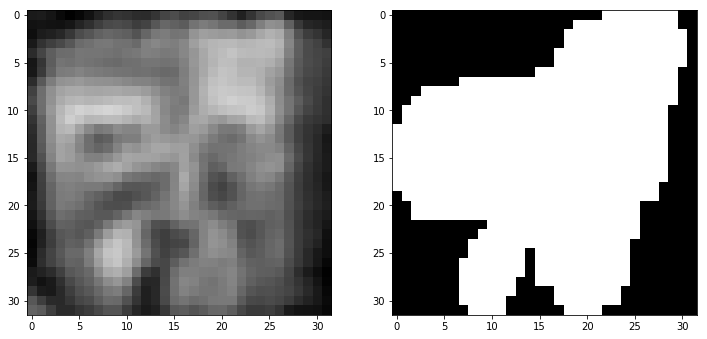

In [4]:
print(X_train.shape)
t_img = X_train[1]/255.0
m_img = Y_train[1]
fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(np.clip(255*t_img, 0, 255).astype(np.uint8) if t_img.shape[2]==3 else t_img[:,:,0],
              interpolation = 'none', cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

In [5]:
net = cx.Network(name = "MiniUNet")
base_depth = 8

In [6]:
net.add(cx.ImageLayer("input", (IMG_WIDTH, IMG_HEIGHT) , IMG_CHANNELS)) 
net.add(cx.BatchNormalizationLayer("bnorm"))
c2 = lambda i, j, act = "relu": cx.Conv2DLayer("conv_{}".format(i, j), j, (3, 3), padding='same', activation=act)
net.add(c2(0, base_depth))
net.add(c2(1, base_depth))
net.add(cx.MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25))
net.add(c2(2, 2*base_depth))
net.add(c2(3, 2*base_depth))
net.add(cx.MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25))
net.add(c2(4, 4*base_depth))
net.add(c2(5, 4*base_depth))
net.add(cx.UpSampling2DLayer("up2", size = (2,2)))
net.add(cx.ConcatenateLayer("cat2"))
net.add(c2(6, 2*base_depth))
net.add(c2(7, 2*base_depth))
net.add(cx.UpSampling2DLayer("up1", size = (2,2)))
net.add(cx.ConcatenateLayer("cat1"))
net.add(c2(8, 2*base_depth))
net.add(cx.Conv2DLayer("output", 1, (1, 1), padding='same', activation='sigmoid'));

In [7]:
net.connect('input', 'bnorm')
net.connect('bnorm', 'conv_0')
net.connect('bnorm', 'cat1')
net.connect('conv_0', 'conv_1')

In [8]:
net.connect('conv_1', 'pool1')
net.connect('pool1', 'conv_2')
net.connect('conv_2', 'conv_3')
net.connect('conv_3', 'pool2')
net.connect('pool2', 'conv_4')
net.connect('conv_4', 'conv_5')
net.connect('conv_5', 'up2')
net.connect('up2', 'cat2')
net.connect('conv_3', 'cat2')
net.connect('cat2', 'conv_6')
net.connect('conv_6', 'conv_7')
net.connect('conv_7', 'up1')
net.connect('up1', 'cat1')
net.connect('cat1', 'conv_8')
net.connect('conv_8', 'output')


In [9]:
net.compile(error="binary_crossentropy", optimizer="adam")

         but not using the 'softmax' activation function on layer 'output'


<IPython.core.display.Javascript object>


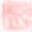
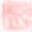
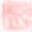
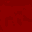
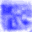
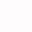
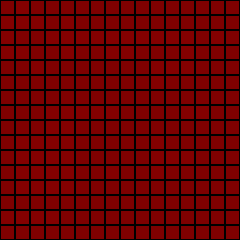
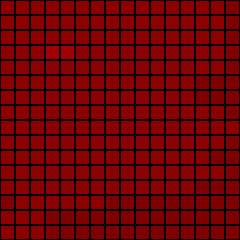
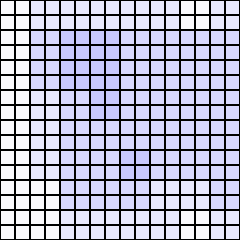
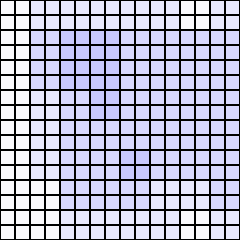
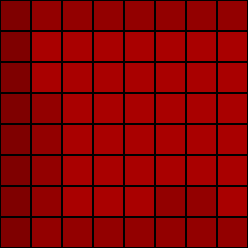
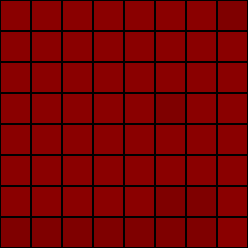
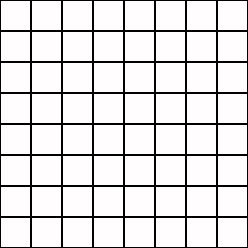
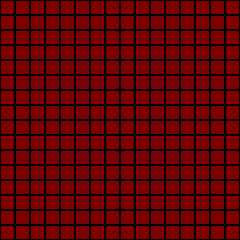
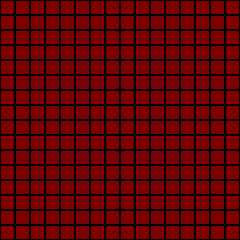
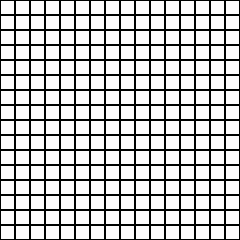
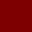
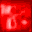
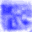
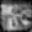

In [10]:
net.picture(t_img, dynamic = True, rotate = True, show_targets = True, show_errors=True, scale = 1.0)

In [11]:
net.dataset.clear()
ip_pairs = [(x/255.0,y*1.0) for x,y in zip(X_train, Y_train)]
net.dataset.append(ip_pairs)
net.dataset.split(0.25)

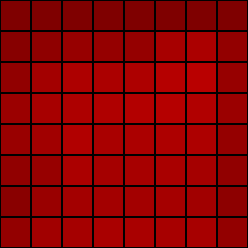

In [12]:
net.propagate_to_image("conv_5", t_img, scale = 1)

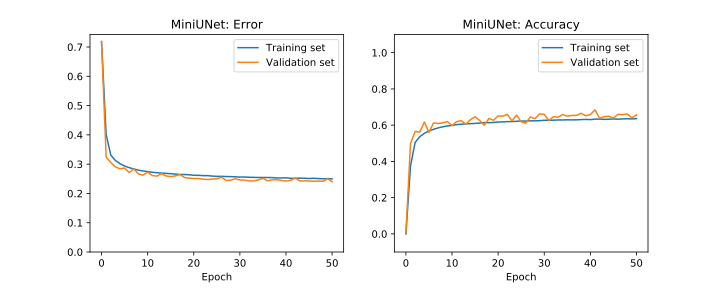

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   50 |   0.24971 |   0.63617 |   0.24017 |   0.65642 


In [13]:
net.train(epochs=50, record=True)

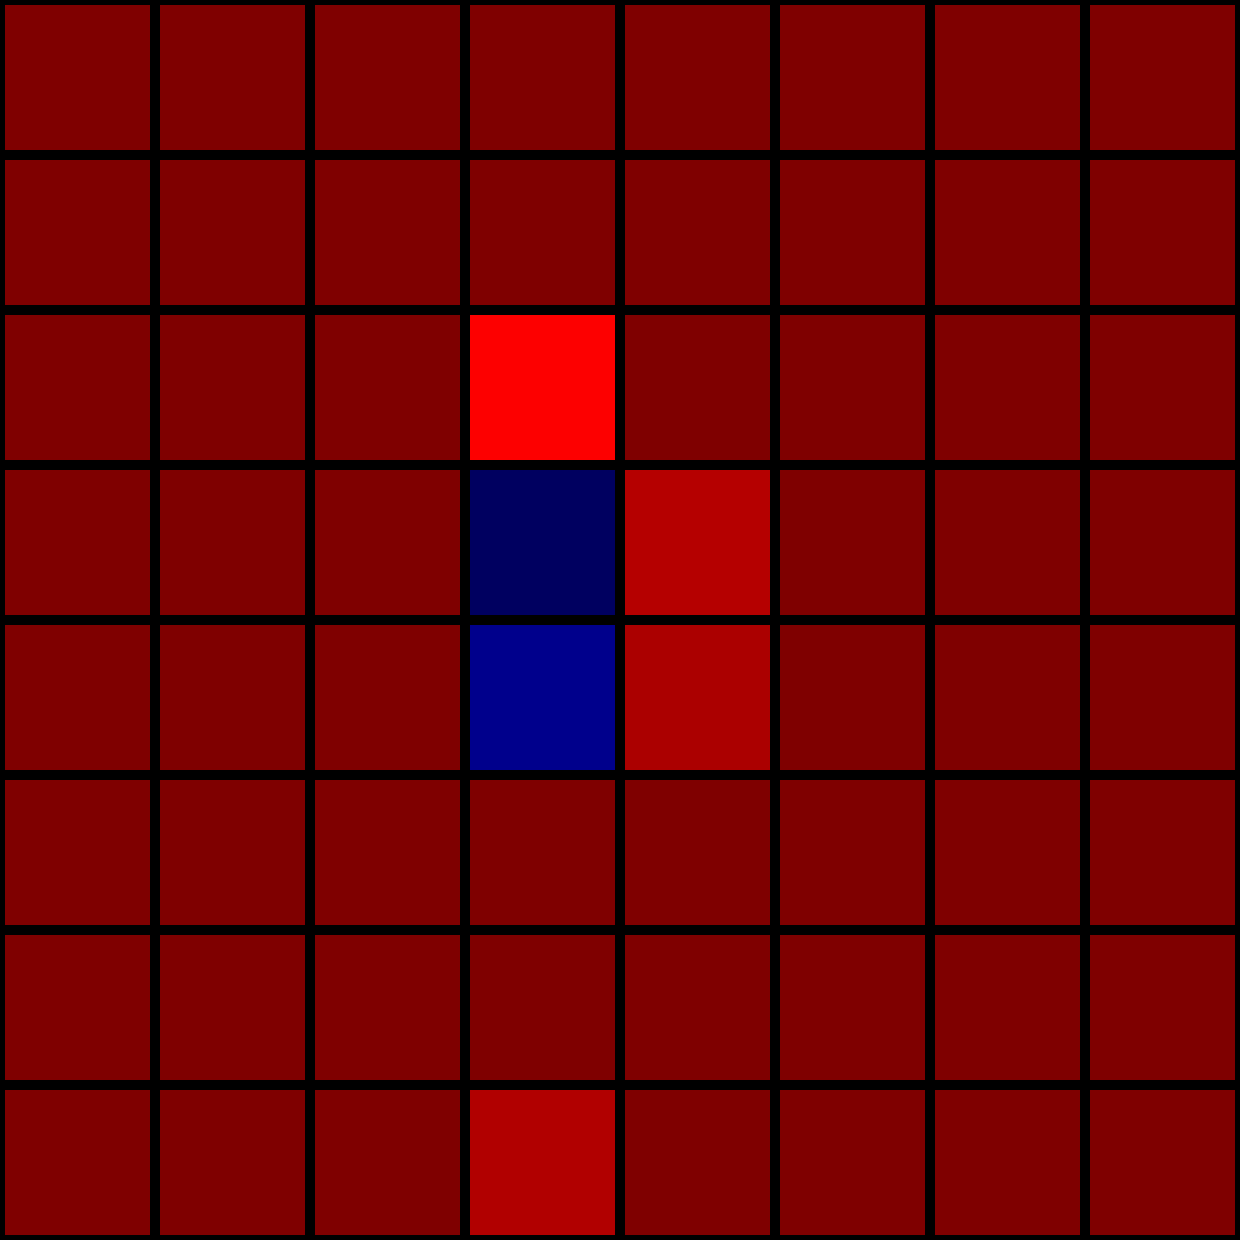

In [14]:
net.propagate_to_image("conv_5", t_img, scale = 5)


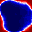
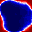
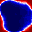
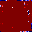
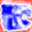
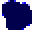
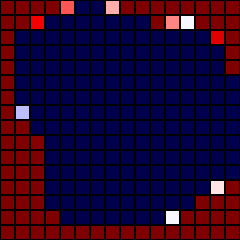
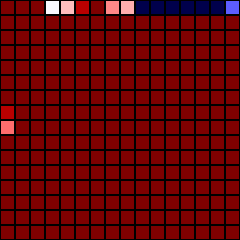
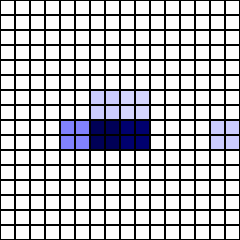
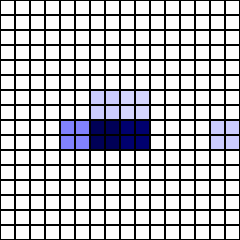
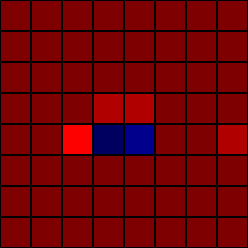
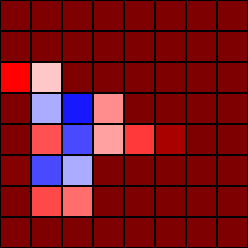
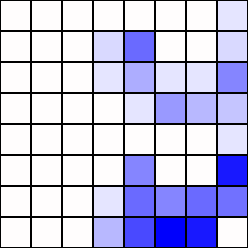
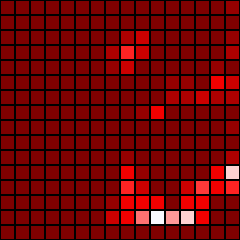
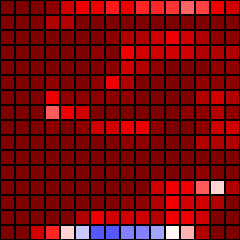
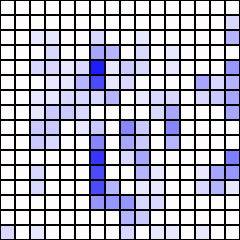
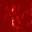
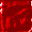
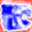
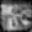

In [15]:
net.picture(t_img, dynamic = True, rotate = True, show_targets = True, show_errors=True, scale = 1.25)

In [16]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

In [17]:
net.movie(lambda net, epoch: net.propagate_to_image("conv_5", t_img, scale = 3), 
                'mid_conv.gif', mp4 = False)

In [18]:
net.movie(lambda net, epoch: net.propagate_to_image("conv_8", t_img, scale = 3), 
                'hr_conv.gif', mp4 = False)

In [19]:
net.movie(lambda net, epoch: net.propagate_to_image("output", t_img, scale = 3), 
                'output.gif', mp4 = False)